In [2]:
# importation de quelques librairies

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import numpy as np

# importation des librairies pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [3]:
# chemin de nos données d'entrainement et de test

train_path = '../data/data_cla/stars_train_new.csv' # replace with your path
test_path = '../data/data_cla/stars_test_new.csv' # replace with your path

# chargement des données

df_train = pd.read_csv(train_path).drop('obj_ID', axis=1)
df_test = pd.read_csv(test_path)

## Analyse des données

In [4]:
# visualisation des données

df_train.head()

,alpha,delta,u,g,r,i,z,redshift,label
0,232.502422,45.121027,25.65923,22.36003,21.22009,20.18024,19.43329,0.547620,0
1,129.290210,48.672374,20.28340,20.09267,19.96514,19.58195,19.42377,1.673636,2
2,256.078422,35.629789,22.09653,22.06431,21.81846,21.55368,20.71617,1.141341,2
3,15.237270,11.871627,22.53424,21.76865,21.77098,21.59392,22.15125,0.000447,1
4,128.023708,25.454899,22.99427,21.43313,19.53053,18.75837,18.35530,0.453795,0


In [5]:
# informations sur les données

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52295 entries, 0 to 52294
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   alpha     52295 non-null  float64
 1   delta     52295 non-null  float64
 2   u         52295 non-null  float64
 3   g         52295 non-null  float64
 4   r         52295 non-null  float64
 5   i         52295 non-null  float64
 6   z         52295 non-null  float64
 7   redshift  52295 non-null  float64
 8   label     52295 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 3.6 MB


In [6]:
# description des données

df_train.describe()

,alpha,delta,u,g,r,i,z,redshift,label
count,52295.000000,52295.000000,52295.000000,52295.000000,52295.000000,52295.000000,52295.000000,52295.000000,52295.00000
mean,179.950018,24.176598,22.162707,20.691976,19.676736,19.095594,18.769568,0.573293,0.56929
std,95.692902,19.417517,2.269335,2.054398,1.860475,1.752333,1.755465,0.726127,0.77704
min,0.013337,-17.636198,10.996230,10.498200,9.822070,9.469903,9.612333,-0.009971,0.00000
25%,129.158091,6.261014,20.398010,19.012810,18.176300,17.764080,17.489495,0.061434,0.00000
50%,182.750060,23.289472,22.314630,21.190710,20.164010,19.419960,19.009600,0.434668,0.00000
75%,236.194344,39.359462,23.785235,22.187810,21.069815,20.391470,19.893945,0.691771,1.00000
max,359.999615,83.000519,30.660390,31.602240,29.571860,30.250090,28.238290,7.011245,2.00000


In [7]:
# forme des données

print(df_train.shape, df_test.shape)

(52295, 9) (25758, 9)


([<matplotlib.axis.XTick at 0x28d9bfb90>,
 [Text(0, 0, '0'), Text(1, 0, '1'), Text(2, 0, '2')])

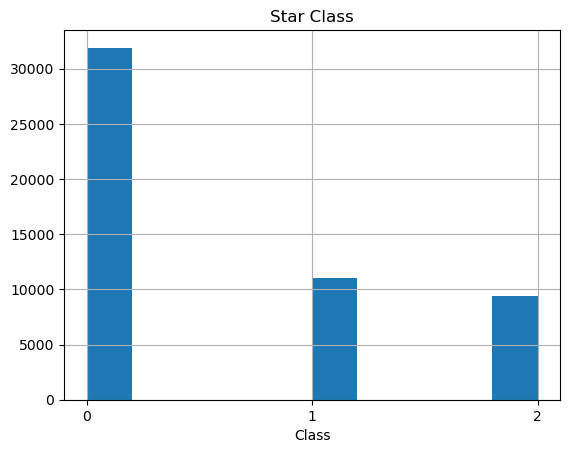

In [8]:
# Disrtibution des classes

df_train['label'].hist()
plt.title('Star Class')
plt.xlabel('Class')
plt.xticks([0,1,2])

Text(0.5, 1.0, 'Correlation Matrix')

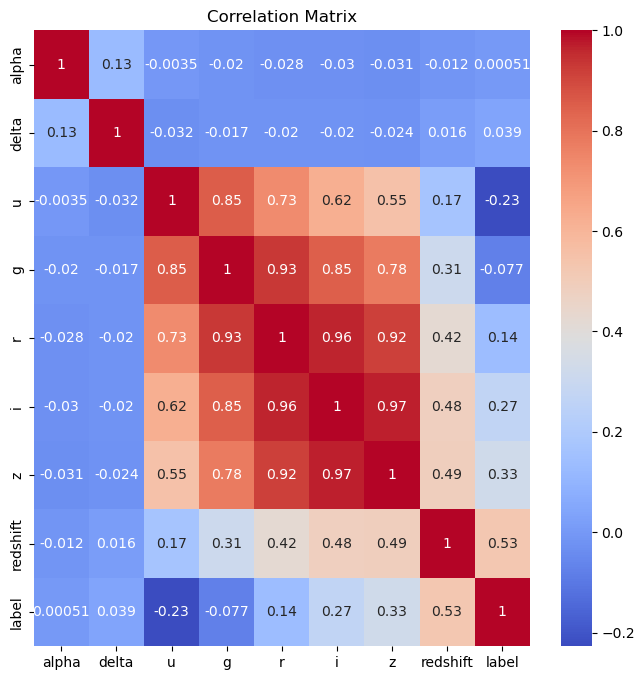

In [9]:
# Matrice de corrélation

plt.figure(figsize=(8, 8))
sns.heatmap(df_train.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')

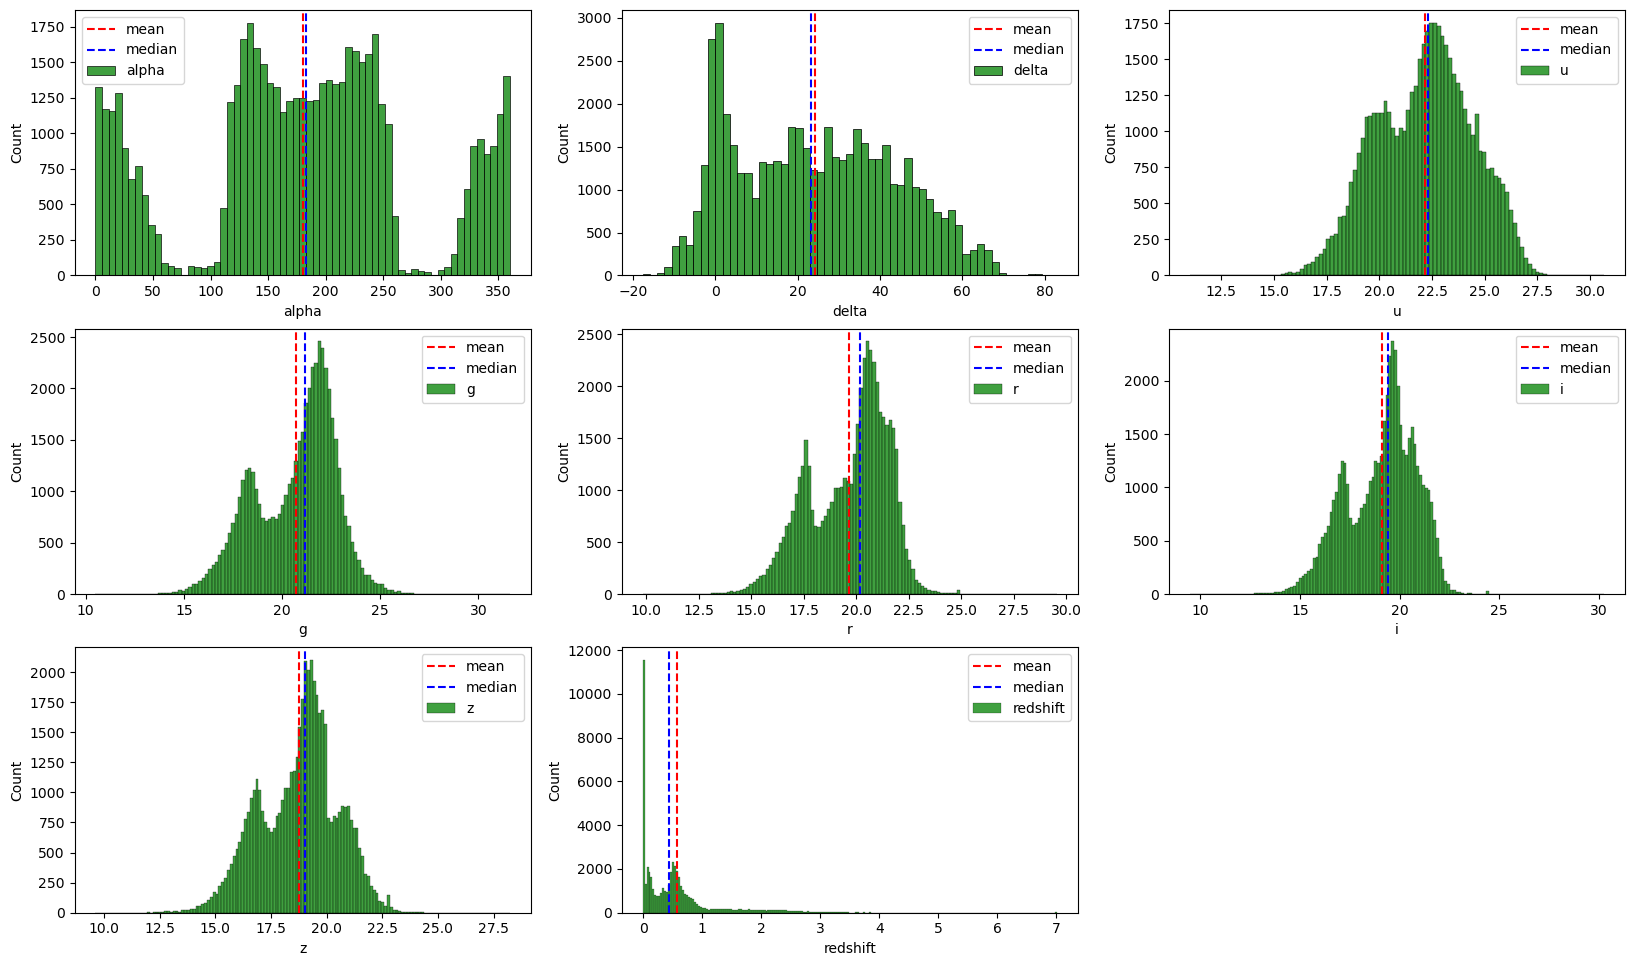

In [10]:
# Distribution des variables

fig = plt.figure(figsize=(20, 20))
for i in range(len(df_train.columns)-1):
    fig.add_subplot(5, 3, i+1)
    sns.histplot(df_train.iloc[:, i], color='green', label=df_train.columns[i])
    # show the mean and median
    plt.axvline(df_train.iloc[:, i].mean(), linestyle='dashed', color='red', label='mean')
    plt.axvline(df_train.iloc[:, i].median(), linestyle='dashed', color='blue', label='median')
    plt.legend()

## Séparation train-test

In [11]:
# Séparation des données en train test

X = df_train.drop('label', axis=1)
y = df_train['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

## Random Forest Classifier

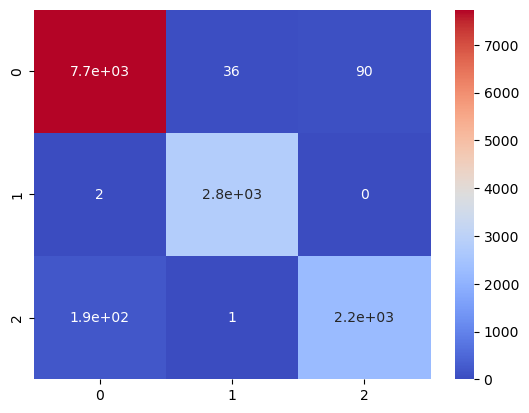

In [13]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

best_params = {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}

if best_params is None:

    # Définition de notre espaces de paramètres

    params = {
        'n_estimators': [10, 50, 100, 200],
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 5]
    }

    # Recherche des meilleurs paramètres
    grid = GridSearchCV(rf, params, cv=5, n_jobs=-1, verbose=1)

    grid.fit(X_train, y_train)

    print(f"paramètres optimaux : {grid.best_params_}")

    print(f"meilleur score : {grid.best_score_}")

    best_params = grid.best_params_

rf.set_params(**best_params)

rf.fit(X_train, y_train)

# Prédiction sur les données de test

y_preds = rf.predict(X_test)

# Matrice de confusion

sns.heatmap(confusion_matrix(y_test, y_preds), annot=True, cmap='coolwarm')

# Sauvegarde des résultats pour streamlit

new_results = pd.DataFrame({'y_test': y_test,
                            'y_preds': y_preds})

new_results.to_csv('../résultats_models/classif/random_forest.csv', index=False)

# soumission des résultats

rf = RandomForestClassifier(**grid.best_params_)

rf.fit(df_train.drop('label', axis=1), df_train['label'])

y_preds = rf.predict(df_test.drop('obj_ID', axis=1))

submission = pd.DataFrame({'obj_ID': df_test['obj_ID'],
                            'label': y_preds})

submission.to_csv('../soumission/classif/random_forest.csv', index=False)

## CatBoost Classifier

In [ ]:
from catboost import CatBoostClassifier

# Définition de notre modèle

cat = CatBoostClassifier(n_estimators=3000, max_depth=10, learning_rate=0.01)

# Entrainement du modèle

cat.fit(X_train, y_train, verbose=1)

# Prédiction sur les données de test

y_preds = cat.predict(X_test)

# Matrice de confusion

sns.heatmap(confusion_matrix(y_test, y_preds), annot=True, cmap='coolwarm')

# Sauvegarde des résultats pour streamlit

new_results = pd.DataFrame({'y_test': y_test,
                            'y_preds': y_preds.ravel()})

new_results.to_csv('../résultats_models/classif/catboost.csv', index=False)

# soumission des résultats

cat = CatBoostClassifier(n_estimators=3000, max_depth=10, learning_rate=0.01)

cat.fit(df_train.drop('label', axis=1), df_train['label'], verbose=1)

y_preds = cat.predict(df_test.drop('obj_ID', axis=1))

submission = pd.DataFrame({'obj_ID': df_test['obj_ID'],
                            'label': y_preds.ravel()})

submission.to_csv('../soumission/classif/catboost.csv', index=False)


## Neural Network

In [167]:
trainset = TensorDataset(torch.from_numpy(X_train.values).float(), torch.from_numpy(y_train.values).long())
testset = TensorDataset(torch.from_numpy(X_test.values).float(), torch.from_numpy(y_test.values).long())

trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
testloader = DataLoader(testset, batch_size=32, shuffle=False)

fullset = TensorDataset(torch.from_numpy(df_train.drop('label', axis=1).values).float(), torch.from_numpy(df_train['label'].values).long())
fullset_loder = DataLoader(fullset, batch_size=32, shuffle=True)
full_testset = TensorDataset(torch.from_numpy(df_test.drop('obj_ID', axis=1).values).float())

In [168]:
class NeuralNetClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out
    

model = NeuralNetClassifier(input_size=8, hidden_size=5, num_classes=3)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

In [169]:
for epoch in range(15):
    for i, (inputs, labels) in enumerate(trainloader):
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        for inputs, labels in testloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
        acc = 100.0 * n_correct / n_samples
        print(f'epoch {epoch+1}/{15}, loss={loss.item():.4f} accuracy = {acc}')

# Prédiction sur les données de test
y_preds = []
with torch.no_grad():
    for inputs in testset:
        outputs = model(inputs[0])
        _, predicted = torch.max(outputs.data, 0)
        y_preds.append(predicted.item())

new_results = pd.DataFrame({'y_test': y_test,
                            'y_preds': y_preds})

new_results.to_csv('../résultats_models/classif/neural_net.csv', index=False)



epoch 1/15, loss=0.4296 accuracy = 74.55254703992657
epoch 2/15, loss=0.5321 accuracy = 74.39192290041304
epoch 3/15, loss=0.5732 accuracy = 75.47039926571821
epoch 4/15, loss=0.4148 accuracy = 77.89505889551782
epoch 5/15, loss=0.4128 accuracy = 86.87471317117944
epoch 6/15, loss=0.4916 accuracy = 89.76594768242313
epoch 7/15, loss=0.1054 accuracy = 91.00504818724185
epoch 8/15, loss=0.3282 accuracy = 93.4220590484932
epoch 9/15, loss=0.2149 accuracy = 93.55208811381368
epoch 10/15, loss=0.2386 accuracy = 94.00336545816124
epoch 11/15, loss=0.1587 accuracy = 93.90393146703381
epoch 12/15, loss=0.0789 accuracy = 94.70705216460149
epoch 13/15, loss=0.2625 accuracy = 94.85237876701851
epoch 14/15, loss=0.1731 accuracy = 94.72234970169802
epoch 15/15, loss=0.2286 accuracy = 95.12773443475601


In [171]:
model = NeuralNetClassifier(input_size=8, hidden_size=5, num_classes=3)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

model = NeuralNetClassifier(input_size=8, hidden_size=5, num_classes=3)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

for epoch in range(30):
    for i, (inputs, labels) in enumerate(fullset_loder):
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        for inputs, labels in testloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
        acc = 100.0 * n_correct / n_samples
        print(f'epoch {epoch+1}/{15}, loss={loss.item():.4f} accuracy = {acc}')

with torch.no_grad():
    y_preds = []
    for inputs in full_testset:
        outputs = model(inputs[0])
        _, predicted = torch.max(outputs.data, 0)
        y_preds.append(predicted.item())

submission = pd.DataFrame({'obj_ID': df_test['obj_ID'],
                            'label': y_preds})

submission.to_csv('../soumission/classif/neural_net.csv', index=False)

epoch 1/15, loss=0.8666 accuracy = 72.29616031818877
epoch 2/15, loss=0.9498 accuracy = 74.7590637907297
epoch 3/15, loss=0.4636 accuracy = 78.65228698179592
epoch 4/15, loss=0.3638 accuracy = 89.29172403243078
epoch 5/15, loss=0.2998 accuracy = 88.66452501147316
epoch 6/15, loss=0.1403 accuracy = 90.33960532354291
epoch 7/15, loss=0.1673 accuracy = 89.15404619856203
epoch 8/15, loss=0.3662 accuracy = 93.17729845494875
epoch 9/15, loss=0.5687 accuracy = 90.91326296466269
epoch 10/15, loss=0.0840 accuracy = 93.80449747590637
epoch 11/15, loss=0.2790 accuracy = 94.27107235735046
epoch 12/15, loss=0.3162 accuracy = 92.65718219366681
epoch 13/15, loss=0.2782 accuracy = 93.94217530977512
epoch 14/15, loss=0.2695 accuracy = 93.34557136301055
epoch 15/15, loss=0.1629 accuracy = 92.74896741624599
epoch 16/15, loss=0.4664 accuracy = 94.42404772831574
epoch 17/15, loss=0.0621 accuracy = 94.24047728315742
epoch 18/15, loss=0.7192 accuracy = 93.8427413186477
epoch 19/15, loss=0.0985 accuracy = 94.

# SVM

In [19]:
from sklearn.svm import SVC

svc = SVC()

best_params = {'kernel':'poly', 'C':1000}

if best_params is None:
    params = {'kernel': ['poly'],
              'C': [1000],
          }

    grid = GridSearchCV(svc, params, refit=True, verbose=3, n_jobs=-1)

    grid.fit(X_train, y_train)

    print(grid.best_params_)
    print(grid.best_estimator_)
    print(grid.best_score_)
    best_params = grid.best_params_

svc.set_params(**best_params)

svc.fit(X_train, y_train)

y_preds = svc.predict(X_test)

new_results = pd.DataFrame({'y_test': y_test,
                            'y_preds': y_preds})

new_results.to_csv('../résultats_models/classif/svc.csv', index=False)

y_preds = svc.predict(df_test.drop('obj_ID', axis=1))

submission = pd.DataFrame({'obj_ID': df_test['obj_ID'],
                            'label': y_preds})

submission.to_csv('../soumission/classif/svc.csv', index=False)




Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ...............C=1000, kernel=poly;, score=0.913 total time=  46.8s
[CV 5/5] END ...............C=1000, kernel=poly;, score=0.920 total time=  49.6s
[CV 3/5] END ...............C=1000, kernel=poly;, score=0.920 total time=  51.0s
[CV 4/5] END ...............C=1000, kernel=poly;, score=0.921 total time=  51.3s
[CV 2/5] END ...............C=1000, kernel=poly;, score=0.923 total time=  53.1s
{'C': 1000, 'kernel': 'poly'}
SVC(C=1000, kernel='poly')
0.9192780994855385


## Normalisation des données

In [12]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

df_train_scaled = scaler.fit_transform(df_train.drop('label', axis=1))
df_test_scaled = scaler.transform(df_test.drop('obj_ID', axis=1))

## Random Forest Classifier

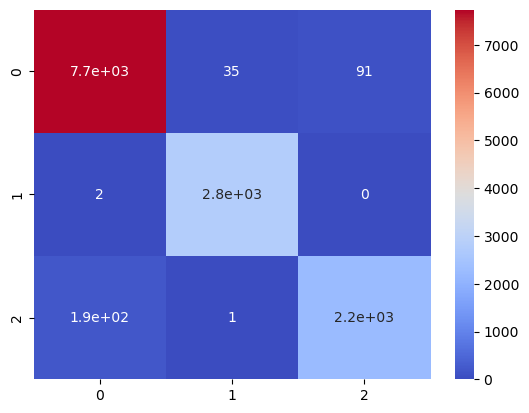

In [26]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

best_params = {'max_depth': 20,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

if best_params is None:

    # Définition de notre espaces de paramètres

    params = {
        'n_estimators': [10, 50, 100, 200],
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 5]
    }

    # Recherche des meilleurs paramètres
    grid = GridSearchCV(rf, params, cv=5, n_jobs=-1, verbose=1)

    grid.fit(X_train_scaled, y_train)

    print(f"paramètres optimaux : {grid.best_params_}")

    print(f"meilleur score : {grid.best_score_}")
    best_params = grid.best_params_

rf.set_params(**best_params)

rf.fit(X_train_scaled, y_train)

# Prédiction sur les données de test

y_preds = rf.predict(X_test_scaled)

# Matrice de confusion

sns.heatmap(confusion_matrix(y_test, y_preds), annot=True, cmap='coolwarm')

# Sauvegarde des résultats pour streamlit

new_results = pd.DataFrame({'y_test': y_test,
                            'y_preds': y_preds})

new_results.to_csv('../résultats_models/classif/random_forest_scaled.csv', index=False)

# soumission des résultats

rf = RandomForestClassifier(**grid.best_params_)

rf.fit(df_train_scaled, df_train['label'])

y_preds = rf.predict(df_test_scaled)

submission = pd.DataFrame({'obj_ID': df_test['obj_ID'],
                            'label': y_preds})

submission.to_csv('../soumission/classif/random_forest_scaled.csv', index=False)

# CatBoost Classifier

0.9765182805568303
0:	learn: 1.0808328	total: 25.5ms	remaining: 1m 16s
1:	learn: 1.0635779	total: 49.3ms	remaining: 1m 13s
2:	learn: 1.0472514	total: 73ms	remaining: 1m 12s
3:	learn: 1.0311584	total: 105ms	remaining: 1m 19s
4:	learn: 1.0158006	total: 133ms	remaining: 1m 19s
5:	learn: 1.0003502	total: 157ms	remaining: 1m 18s
6:	learn: 0.9856835	total: 180ms	remaining: 1m 16s
7:	learn: 0.9709301	total: 206ms	remaining: 1m 16s
8:	learn: 0.9566964	total: 230ms	remaining: 1m 16s
9:	learn: 0.9430631	total: 251ms	remaining: 1m 14s
10:	learn: 0.9295033	total: 269ms	remaining: 1m 13s
11:	learn: 0.9162926	total: 288ms	remaining: 1m 11s
12:	learn: 0.9033132	total: 310ms	remaining: 1m 11s
13:	learn: 0.8905197	total: 331ms	remaining: 1m 10s
14:	learn: 0.8779617	total: 350ms	remaining: 1m 9s
15:	learn: 0.8657791	total: 370ms	remaining: 1m 8s
16:	learn: 0.8540078	total: 391ms	remaining: 1m 8s
17:	learn: 0.8423065	total: 415ms	remaining: 1m 8s
18:	learn: 0.8309406	total: 437ms	remaining: 1m 8s
19:	lea

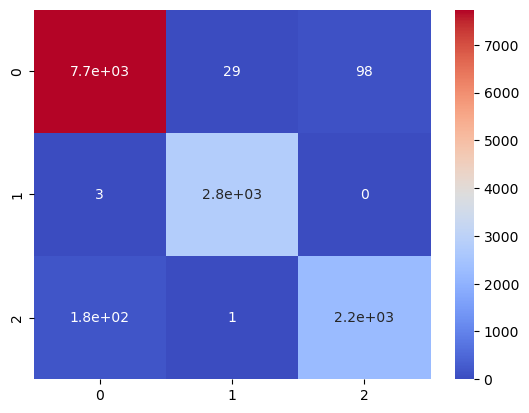

In [13]:
from catboost import CatBoostClassifier

# Définition de notre modèle

cat = CatBoostClassifier(n_estimators=3000, max_depth=10, learning_rate=0.01)

# Entrainement du modèle

cat.fit(X_train_scaled, y_train, verbose=0)

# Prédiction sur les données de test

y_preds = cat.predict(X_test_scaled)

# Matrice de confusion

sns.heatmap(confusion_matrix(y_test, y_preds), annot=True, cmap='coolwarm')

# Sauvegarde des résultats pour streamlit

new_results = pd.DataFrame({'y_test': y_test,
                            'y_preds': y_preds.ravel()})

print(np.sum(y_test == y_preds.ravel()) / len(y_test))

new_results.to_csv('../résultats_models/classif/catboost_scaled.csv', index=False)

# soumission des résultats

cat = CatBoostClassifier(n_estimators=3000, max_depth=10, learning_rate=0.01)

cat.fit(df_train_scaled, df_train['label'], verbose=0)

y_preds = cat.predict(df_test_scaled)

submission = pd.DataFrame({'obj_ID': df_test['obj_ID'],
                            'label': y_preds.ravel()})

submission.to_csv('../soumission/classif/catboost_scaled.csv', index=False)


## Neural Network

In [15]:
trainset = TensorDataset(torch.from_numpy(X_train_scaled).float(), torch.from_numpy(y_train.values).long())
testset = TensorDataset(torch.from_numpy(X_test_scaled).float(), torch.from_numpy(y_test.values).long())

trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
testloader = DataLoader(testset, batch_size=32, shuffle=False)

fullset = TensorDataset(torch.from_numpy(df_train_scaled).float(), torch.from_numpy(df_train['label'].values).long())
fullset_loder = DataLoader(fullset, batch_size=32, shuffle=True)
full_testset = TensorDataset(torch.from_numpy(df_test_scaled).float())

In [16]:
class NeuralNetClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out
    

model = NeuralNetClassifier(input_size=8, hidden_size=5, num_classes=3)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

In [19]:
for epoch in range(50):
    for i, (inputs, labels) in enumerate(trainloader):
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        for inputs, labels in testloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
        acc = 100.0 * n_correct / n_samples
        print(f'epoch {epoch+1}/{50}, loss={loss.item():.4f} accuracy = {acc}')

# Prédiction sur les données de test
y_preds = []
with torch.no_grad():
    for inputs in testset:
        outputs = model(inputs[0])
        _, predicted = torch.max(outputs.data, 0)
        y_preds.append(predicted.item())

new_results = pd.DataFrame({'y_test': y_test,
                            'y_preds': y_preds})

new_results.to_csv('../résultats_models/classif/neural_net_scaled.csv', index=False)



epoch 1/50, loss=0.0289 accuracy = 96.27504971699557
epoch 2/50, loss=0.2094 accuracy = 96.14502065167508
epoch 3/50, loss=0.0493 accuracy = 96.38978124521952
epoch 4/50, loss=0.0378 accuracy = 96.31329355973688
epoch 5/50, loss=0.0458 accuracy = 96.21385956860945
epoch 6/50, loss=0.0320 accuracy = 96.38213247667126
epoch 7/50, loss=0.0623 accuracy = 96.35918617102647
epoch 8/50, loss=0.2447 accuracy = 96.21385956860945
epoch 9/50, loss=0.1579 accuracy = 96.15266942022335
epoch 10/50, loss=0.2731 accuracy = 96.39743001376779
epoch 11/50, loss=0.2207 accuracy = 96.23680587425424
epoch 12/50, loss=0.1139 accuracy = 96.20621080006119
epoch 13/50, loss=0.0235 accuracy = 96.42802508796083
epoch 14/50, loss=0.0557 accuracy = 95.99969404925807
epoch 15/50, loss=0.0198 accuracy = 96.29799602264036
epoch 16/50, loss=0.2233 accuracy = 96.15266942022335
epoch 17/50, loss=0.0204 accuracy = 96.3285910968334
epoch 18/50, loss=0.1507 accuracy = 96.30564479118861
epoch 19/50, loss=0.0312 accuracy = 96

In [20]:
model = NeuralNetClassifier(input_size=8, hidden_size=5, num_classes=3)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

model = NeuralNetClassifier(input_size=8, hidden_size=5, num_classes=3)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

for epoch in range(50):
    for i, (inputs, labels) in enumerate(fullset_loder):
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        for inputs, labels in testloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
        acc = 100.0 * n_correct / n_samples
        print(f'epoch {epoch+1}/{50}, loss={loss.item():.4f} accuracy = {acc}')

with torch.no_grad():
    y_preds = []
    for inputs in full_testset:
        outputs = model(inputs[0])
        _, predicted = torch.max(outputs.data, 0)
        y_preds.append(predicted.item())

submission = pd.DataFrame({'obj_ID': df_test['obj_ID'],
                            'label': y_preds})

submission.to_csv('../soumission/classif/neural_net_scaled.csv', index=False)

epoch 1/50, loss=0.2214 accuracy = 88.02967722196726
epoch 2/50, loss=0.2787 accuracy = 92.2594462291571
epoch 3/50, loss=0.4901 accuracy = 93.57503441945846
epoch 4/50, loss=0.0913 accuracy = 94.11044821783693
epoch 5/50, loss=0.7317 accuracy = 94.54642802508796
epoch 6/50, loss=0.1436 accuracy = 94.8753250726633
epoch 7/50, loss=0.2338 accuracy = 95.13538320330427
epoch 8/50, loss=0.0956 accuracy = 95.34189995410739
epoch 9/50, loss=0.0291 accuracy = 95.47957778797614
epoch 10/50, loss=0.0706 accuracy = 95.5943093162001
epoch 11/50, loss=0.1990 accuracy = 95.60960685329663
epoch 12/50, loss=0.0333 accuracy = 95.56371424200704
epoch 13/50, loss=0.1245 accuracy = 95.78552852990668
epoch 14/50, loss=0.0709 accuracy = 95.60195808474836
epoch 15/50, loss=0.2566 accuracy = 95.94615266942023
epoch 16/50, loss=0.0574 accuracy = 95.76258222426189
epoch 17/50, loss=0.4380 accuracy = 95.73198715006883
epoch 18/50, loss=0.0662 accuracy = 95.96145020651674
epoch 19/50, loss=0.0466 accuracy = 96.1

# SVC

In [29]:
from sklearn.svm import SVC

svc = SVC()


from sklearn.svm import SVC

svc = SVC()

best_params = {'C': 1000, 'kernel': 'poly'}

if best_params is None:
    params = {'kernel': ['poly'],
              'C': [1, 10, 100, 1000],
          }

    grid = GridSearchCV(svc, params, refit=True, verbose=3, n_jobs=-1)

    grid.fit(X_train_scaled, y_train)

    print(grid.best_params_)
    print(grid.best_estimator_)
    print(grid.best_score_)
    best_params = grid.best_params_

svc.set_params(**best_params)

svc.fit(X_train_scaled, y_train)

y_preds = svc.predict(X_test_scaled)

new_results = pd.DataFrame({'y_test': y_test,
                            'y_preds': y_preds})

new_results.to_csv('../résultats_models/classif/svc_scaled.csv', index=False)

y_preds = svc.predict(df_test_scaled)

submission = pd.DataFrame({'obj_ID': df_test['obj_ID'],
                            'label': y_preds})

submission.to_csv('../soumission/classif/svc_scaled.csv', index=False)